<a href="https://colab.research.google.com/github/titika2013/adv_ml_made_2022/blob/main/made_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import sparse
from scipy.special import logit, expit
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm


## Часть 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю: взять в тренировочный набор турниры с dateStart из 2019 года; в тестовый — турниры с dateStart из 2020 года.

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
result_path = "/content/drive/MyDrive/chgk/results.pkl"
players_path = "/content/drive/MyDrive/chgk/players.pkl"
tournaments_path = "/content/drive/MyDrive/chgk/tournaments.pkl"

In [4]:
# result_df = pd.DataFrame(pd.read_pickle(result_path))
players_df = pd.DataFrame(pd.read_pickle(players_path)).T
tournaments_df = pd.DataFrame(pd.read_pickle(tournaments_path)).T

results_dict = pd.read_pickle(result_path)

In [5]:
tournaments_df = pd.DataFrame(pd.read_pickle(tournaments_path)).T

In [6]:
train_t = tournaments_df.loc[(tournaments_df['dateStart'] >= '2019-01-01') & (tournaments_df['dateStart'] < '2020')]
train_t = train_t.sort_values(by=['dateStart'])
train_t["questionQty"] = train_t["questionQty"].apply(lambda x: sum(x.values()))

test_t = tournaments_df.loc[(tournaments_df['dateStart'] >= '2020') & (tournaments_df['dateStart'] < '2021')]
test_t = test_t.sort_values(by=['dateStart'])
test_t["questionQty"] = test_t["questionQty"].apply(lambda x: sum(x.values()))
test_ids = test_t.id.values

print(train_t.shape, test_t.shape)

(687, 9) (418, 9)


In [7]:
def prepare_data(in_df):
    in_df_id = in_df.id.values
    res = []
    el_num = 0
    for c_id in in_df_id:
        for team_res in results_dict[c_id]:
            if 'mask' in team_res.keys() and team_res["mask"]:
                if team_res["mask"].isdigit():
                    # pp.pprint(team_res)
                    for player in team_res['teamMembers']:
                        # ограничим длину маски
                        if len(team_res["mask"]) != in_df["questionQty"].values[el_num]:
                            continue

                        res.append({
                            "team_id": team_res["team"]['id'],
                            "team_name": team_res["team"]["name"],
                            "team_position": team_res["position"],

                            "tournament_id": c_id,
                            "tournament_name": in_df["name"].values[el_num],

                            "player_name": "{} {} {}".format(player["player"]["surname"], player["player"]["name"],
                                                             player["player"]["patronymic"]),
                            'player_rating': player["rating"],
                            'player_id': player["player"]['id'],

                            'mask': team_res["mask"],
                            'len_mask': len(team_res["mask"]),
                        })
        el_num += 1
    return pd.DataFrame(res)


train_res_df = prepare_data(train_t)
test_res_df = prepare_data(test_t)
# Освободим память  (мало оперативной памяти)
del results_dict

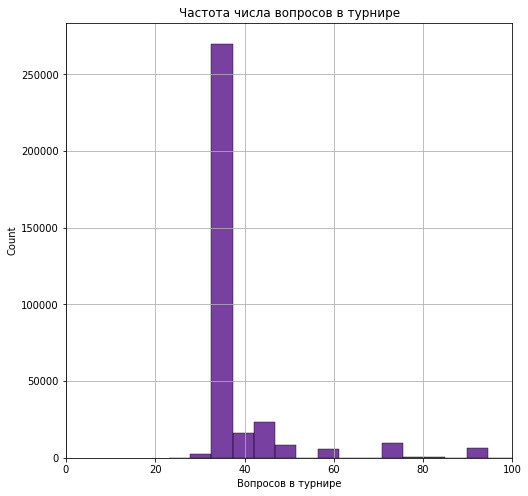

In [8]:
# Число вопросов
plt.figure(figsize=(8, 8))
sns.histplot(train_res_df["len_mask"], bins=100, color="indigo")
plt.grid()
plt.xlim([0, 100])
plt.xlabel("Вопросов в турнире")
plt.title("Частота числа вопросов в турнире")
plt.show()


## Часть 2 - baseline-модель 

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки: повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;

Обучим Логистическую регрессию. В качестве признаков будем использовать id игроков и повопросные результаты, тем самым будем учитывать силу игроков и сложность вопросов. 

Произведем one-hot encoding над id игроков и повопросыми результатами, получим разряженную матрицу признаков, в которой число столбцов соответствует сумме общего числа вопросов и количества игроков, а каждая строка соответствует ответу $i$ игрока на вопрос $j$. В качестве целевой переменной будет ответ игрока $i$  игрока на $j$ вопрос.

In [9]:
# Произведенные операции избыточны, но помогают лучше понять данные

def questo(df):
    question_ans = {
        "team_id": [],
        "player_id": [],
        "player_name": [],
        "team_position": [],
        "tournament_id": [],
        "ans_t_f": [],
        "ask_num": [],

    }
    for row in df.itertuples():
        for q_num, ans in enumerate(row.mask):
            question_ans["team_id"].append(row.team_id)
            question_ans["player_id"].append(row.player_id)
            question_ans["player_name"].append(row.player_name)
            question_ans["team_position"].append(row.team_position)
            question_ans["tournament_id"].append(row.tournament_id)
            question_ans["ans_t_f"].append(int(ans))
            question_ans["ask_num"].append("{}_{}".format(row.tournament_id, q_num))

    return pd.DataFrame(question_ans)


def prepare_train_data(df):
    temp_player = df[["player_id", "ans_t_f"]].groupby(['player_id']).mean().rename(
        columns={"ans_t_f": "player_ans_mean"})
    temp_player_q = df[["player_id", "ans_t_f"]].groupby(['player_id']).count().rename(
        columns={"ans_t_f": "questions_count"})
    temp_torn = df[["tournament_id", "ans_t_f"]].groupby(['tournament_id']).mean().rename(
        columns={"ans_t_f": "tournament_ans_mean"})
    df = df.merge(temp_player, on='player_id', how='left')
    df = df.merge(temp_player_q, on='player_id', how='left')
    df = df.merge(temp_torn, on='tournament_id', how='left')
    df['player_id_new'] = df.groupby(['player_id']).ngroup()
    df['ask_num_new'] = df.groupby(['ask_num']).ngroup() + len(df["player_id_new"].unique())
    df['ask_num_new'] = df.groupby(['ask_num']).ngroup() + len(df["player_id_new"].unique())
    return df


In [10]:
train_data = prepare_train_data(questo(train_res_df)).sort_values(by=['player_id_new'])
test_data = prepare_train_data(questo(test_res_df)).sort_values(by=['player_id_new'])

In [11]:
encoder = OneHotEncoder()
train_x = encoder.fit_transform(train_data[["player_id_new", "ask_num_new"]])
train_y = np.array(train_data["ans_t_f"])

In [12]:
%%time
reg = LogisticRegression(solver="saga")
reg.fit(train_x, train_y)

reg.score


CPU times: user 6min 11s, sys: 303 ms, total: 6min 12s
Wall time: 6min 16s


In [13]:
# import pickle

# pickle.dump(reg, open("/content/drive/MyDrive/chgk/reg_temp_one.sav", 'wb'))
# #reg  = pickle.load(open("/content/drive/MyDrive/chgk/reg_temp_one.sav", 'rb'))

Получим рейтинг игроков и рейтинг вопросов из коофицентов логической регрессии.

In [14]:
def prepare_player_rating_df(model, df):
    player_rating = model.coef_[0][: len(df["player_id_new"].unique())]
    temp_places = pd.DataFrame({'player_id_new': df["player_id_new"].unique(), 'player_rating': player_rating})
    temp_places = temp_places.sort_values(by=['player_rating'], ascending=False)
    temp_places["place"] = np.arange(len(df["player_id_new"].unique())) + 1
    df = df.merge(temp_places, on='player_id_new', how='left')
    df = df.sort_values(by=['player_rating'], ascending=False)
    return df


train_data = prepare_player_rating_df(reg, train_data)

In [15]:
num_of_players = len(train_data["player_id_new"].unique())
question_difficulty = reg.coef_[0][num_of_players:] - reg.intercept_
player_rating = reg.coef_[0][: num_of_players]

n = 15
coefs_to_n = np.argsort(player_rating)[::-1][:n]
rating = []

for i, coef_idx in enumerate(coefs_to_n):
    player_id = coef_idx
    row = train_data.loc[train_data['player_id_new'] == coef_idx].iloc[0]
    row["place"] = i + 1
    row["score"] = player_rating[coef_idx]
    rating.append(row[["player_id", "team_id", "player_name", "place", "score"]])
pd.DataFrame(rating)

,player_id,team_id,player_name,place,score
2211965,27403,49804,Руссо Максим Михайлович,1,4.071559
344571,4270,49804,Брутер Александра Владимировна,2,3.935013
2328660,28751,49804,Семушин Иван Николаевич,3,3.887828
2256175,27822,71550,Савченков Михаил Владимирович,4,3.855398
2482113,30270,49804,Спешков Сергей Леонидович,5,3.761359
2460715,30152,49804,Сорожкин Артём Сергеевич,6,3.755810
1440882,18036,45556,Левандовский Михаил Ильич,7,3.620874
1658923,20691,670,Мереминский Станислав Григорьевич,8,3.616422
5280147,87637,57024,Саксонов Антон Владимирович,9,3.546117
1828090,22799,45556,Николенко Сергей Игоревич,10,3.541694


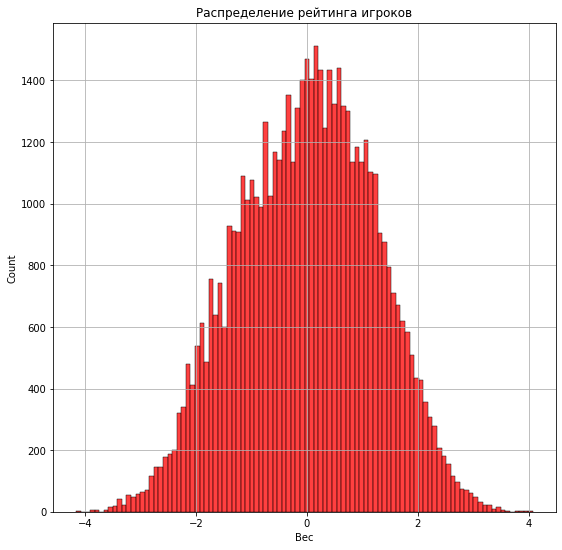

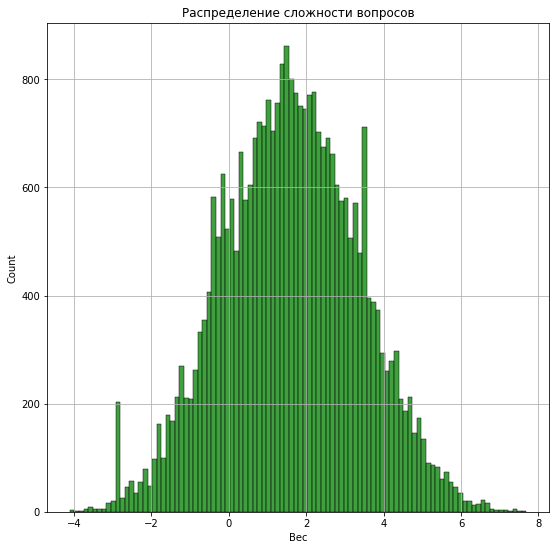

In [16]:
plt.figure(figsize=(9, 9))
sns.histplot(player_rating, bins=100, color="red")
plt.grid()
plt.xlabel("Вес")
plt.title("Распределение рейтинга игроков")
plt.show()


plt.figure(figsize=(9, 9))
sns.histplot(question_difficulty, bins=100, color="green")
plt.grid()
plt.xlabel("Вес")
plt.title("Распределение сложности вопросов")
plt.show()

## Часть 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

Будем считать вероятность ответа игрока на вопрос — это вероятность того что 1 и более игроков в команде ответили правильно, полученную вероятность будем сравнивать с реальной позицией команды полученной из тестовой выборки.

 $P_n = 1 - \Pi_{i \in т}(1 - p_{i})$
, где $p_{i}$ - Вероятность игроку $i$ из команды $n$ ответить на вопрос.

In [17]:
# Подготовим Датасет
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))


train_player_ratings = train_data[["player_id", "player_id_new", "player_rating", "player_name"]].drop_duplicates()
train_player_ratings["sig_rate"] = sigmoid(train_player_ratings["player_rating"])
train_player_ratings['idx'] = train_player_ratings["player_id_new"]
train_player_ratings.set_index('idx', inplace=True)
train_player_ratings.sort_index(inplace=True)

test_data_tour = test_data[["tournament_id", "team_position", "player_id", "team_id"]].drop_duplicates()

In [18]:
def correlation_definer(test_data_tour=test_data_tour):
    spearmanr_values = 0
    kendalltau_values = 0
    test_size = test_data.tournament_id.nunique()
    unic_tournament = test_data_tour.tournament_id.nunique()

    for tour_id, tour_df in test_data_tour.groupby(by=['tournament_id']):
        team_pred_rate = []
        team_true_rate = []

        for team_id, cur_team_df in tour_df.sort_values(by='team_position').groupby(by='team_id'):
            team_rate_mult = 1
            for player_id in cur_team_df['player_id'].values:
                if player_id in train_player_ratings.player_id.values:
                    team_rate_mult *= 1 - train_player_ratings.loc[train_player_ratings['player_id'] == player_id][
                        "sig_rate"].values[0]
                else:
                    team_rate_mult *= 1 - train_player_ratings["sig_rate"].mean()

            team_pred_rate.append(((1 - team_rate_mult), int(cur_team_df['team_position'].values[0])))
            team_true_rate.append(len(team_pred_rate))
        tour_pred = [item[1] for item in sorted(team_pred_rate)]
        spearmanr_values += np.abs(spearmanr(team_true_rate, tour_pred).correlation)
        kendalltau_values += np.abs(kendalltau(team_true_rate, tour_pred).correlation)

    print(f'Усредненный коэффициент Спирмена: {spearmanr_values / test_data.tournament_id.nunique():.3f},',
          f'Усредненный коэффициент Кендалла: {kendalltau_values / test_data.tournament_id.nunique():.3f}')
    return spearmanr_values / test_data.tournament_id.nunique(), kendalltau_values / test_data.tournament_id.nunique()


In [19]:
correlation_definer()

Усредненный коэффициент Спирмена: 0.742, Усредненный коэффициент Кендалла: 0.585


(0.7421416548033484, 0.5853031310445996)

## Часть 4

Инициализируем началальные веса, как вероятности ответов игрока на вопрос не зависимо от команды (получим их из лог регрессии полученной выше)

В ЕМ-схеме на Е-шаге: 
- Вычисляем скрытую переменную $z_i$, показывающую вероятность ответить на вопрос при условии того, что игрок состоит в конкретной команде. Далее предполагаем, что команда отвечает правильно, если хоть один игрок из команды знает верный ответ.

$E\left[z_{q,n,p}\right]=0$. Если команда $n$ не ответила на вопрос $q$

$E\left[z_{q,n,p}\right]= \frac{P(p \mid q, \theta)}{P(n \mid q)}=\frac{P(p \mid q, \theta)}{1-\prod_{p^{\prime} \in n}\left(1-P\left(p^{\prime} \mid q, \theta\right)\right)}$. 
Если команда $n$ ответила на вопрос $q$

На  M-шаге обучаем линейную регрессию с помощью $\operatorname{logit}$.

In [20]:
class EmAlgoritm():

    def __init__(self, model):
        self.best_model = model
        self.model = model
        self.best_sp_corr = 0
        self.best_kn_corr = 0

    def corr_def_help(self):
        train_player_ratings['rating'] = self.model.coef_[: num_of_players]
        train_player_ratings['sig_rate'] = sigmoid(train_player_ratings['rating'])

        return correlation_definer()

    def fit(self, train_df, train_X_, train_y_, n=10):
        print("обучение EM модели ...")
        train_df['rate'] = reg.predict_proba(train_x)[:, 1]
        for _ in tqdm(range(n), position=0, leave=True):
            # E шаг
            train_df['1-rate'] = 1 - train_df['rate']
            teams = 1 - train_df.groupby(['tournament_id', 'team_id', 'ask_num_new'])['1-rate'].prod()
            train_df = train_df.merge(teams.rename('team_rate'), left_on=['tournament_id', 'team_id', 'ask_num_new'],
                                      right_index=True)
            train_df['z'] = train_df['rate'] / train_df['team_rate']
            train_df['z'] = np.where(train_y_ == 0, 0, train_df['z'])
            train_df['z'] = np.clip(train_df['z'], 1e-5, 1 - 1e-5)

            # M шаг
            self.model.fit(train_X_, logit(train_df['z']))
            train_df['rate'] = expit(self.model.predict(train_X_))
            train_df = train_df.drop(columns='team_rate')

            sp_corr, kn_corr = self.corr_def_help()
            if sp_corr > self.best_sp_corr and kn_corr > self.best_kn_corr:
                self.best_sp_corr, self.best_kn_corr = sp_corr, kn_corr
                print(f"Сохранение модели с усредненным коэффициентом Спирмена {sp_corr} и Кендалла {kn_corr}")
                self.best_model = self.model
        train_df.drop(columns='rate')


In [21]:
em_algo = EmAlgoritm(LinearRegression())
em_algo.fit(train_data, train_x, train_y)
best_model = em_algo.best_model

обучение EM модели ...


 10%|█         | 1/10 [03:04<27:38, 184.29s/it]

Усредненный коэффициент Спирмена: 0.759, Усредненный коэффициент Кендалла: 0.605
Сохранение модели с усредненным коэффициентом Спирмена 0.7592159943791806 и Кендалла 0.6049482942943166


 20%|██        | 2/10 [06:20<25:28, 191.07s/it]

Усредненный коэффициент Спирмена: 0.752, Усредненный коэффициент Кендалла: 0.597


 30%|███       | 3/10 [09:54<23:31, 201.58s/it]

Усредненный коэффициент Спирмена: 0.747, Усредненный коэффициент Кендалла: 0.593


 40%|████      | 4/10 [13:27<20:37, 206.30s/it]

Усредненный коэффициент Спирмена: 0.750, Усредненный коэффициент Кендалла: 0.596


 50%|█████     | 5/10 [17:04<17:30, 210.10s/it]

Усредненный коэффициент Спирмена: 0.749, Усредненный коэффициент Кендалла: 0.595


 60%|██████    | 6/10 [20:42<14:11, 212.83s/it]

Усредненный коэффициент Спирмена: 0.749, Усредненный коэффициент Кендалла: 0.595


 70%|███████   | 7/10 [24:17<10:40, 213.62s/it]

Усредненный коэффициент Спирмена: 0.748, Усредненный коэффициент Кендалла: 0.594


 80%|████████  | 8/10 [27:54<07:08, 214.49s/it]

Усредненный коэффициент Спирмена: 0.748, Усредненный коэффициент Кендалла: 0.594


 90%|█████████ | 9/10 [31:29<03:34, 214.68s/it]

Усредненный коэффициент Спирмена: 0.749, Усредненный коэффициент Кендалла: 0.595


100%|██████████| 10/10 [35:06<00:00, 210.70s/it]

Усредненный коэффициент Спирмена: 0.749, Усредненный коэффициент Кендалла: 0.595


In [22]:
# import pickle

# pickle.dump(best_model, open("/content/drive/MyDrive/chgk/best_model_temp_one.sav", 'wb'))
# reg  = pickle.load(open("/content/drive/MyDrive/chgk/best_model_temp_one.sav", 'wb'))

Видно, что с каждым шагом расчетные метрики улучшаются.

In [23]:
# построим новый рейтинг лист исходя из новых результатов
num_of_players = len(train_data["player_id_new"].unique())
question_difficulty = best_model.coef_[num_of_players:] - best_model.intercept_
player_rating = best_model.coef_[: num_of_players]

n = 15
coefs_to_n = np.argsort(player_rating)[::-1][:n]
rating = []

for i, coef_idx in enumerate(coefs_to_n):
    player_id = coef_idx
    row = train_data.loc[train_data['player_id_new'] == coef_idx].iloc[0]
    row["place"] = i + 1
    row["score"] = player_rating[coef_idx]
    rating.append(row[["player_id", "team_id", "player_name", "place", "score"]])
pd.DataFrame(rating)


,player_id,team_id,player_name,place,score
2097093,26026,71961,Приходченко Сергей Дмитриевич,1,10.208957
14620823,218017,76345,Попко Дарья Андреевна,2,9.009919
14522671,215829,75879,Мартиросова Юлия Владимировна,3,8.630847
14177065,210073,67195,Брилёв Арсений,4,8.405477
14177098,210074,67195,Костерева Анастасия,5,8.405477
12213349,190078,69174,Ревтова Марина Николаевна,6,7.882845
5964192,100491,29057,Железов Дмитрий Леонидович,7,7.246106
14652073,219423,76725,Тынгаев Александр,8,7.189079
14620783,218016,76344,Лисовский Евгений,9,7.091101
13168484,199963,72156,Бровченко Елена Борисовна,10,6.977725


# Часть 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [24]:
question = reg.coef_[0][num_of_players:] - reg.intercept_
index_q = dict(np.column_stack((encoder.categories_[1], question)))

In [25]:
rate_list = train_data[['tournament_id', 'ask_num_new']].drop_duplicates()
rate_list['questions_rate'] = -1 * rate_list['ask_num_new'].map(index_q)
rate_list = rate_list.groupby('tournament_id')['questions_rate'].mean().reset_index()
rate_list = rate_list.merge(tournaments_df[['name']], left_on='tournament_id', right_index=True)
rate_list = rate_list.sort_values(by='questions_rate', ascending=False)
rate_list['rate_place'] = np.arange(len(rate_list)) + 1

In [26]:
rate_list.head(15)

,tournament_id,questions_rate,name,rate_place
603,6149,2.830518,Чемпионат Санкт-Петербурга. Первая лига,1
488,5928,0.696936,Угрюмый Ёрш,2
35,5159,0.469526,Первенство правого полушария,3
579,6101,0.377823,Воображаемый музей,4
254,5587,0.195432,Записки охотника,5
12,5025,0.125554,Кубок городов,6
22,5083,0.086222,Ускользающая сова,7
342,5693,0.075472,Знание – Сила VI,8
200,5515,-0.038892,Чемпионат Минска. Лига А. Тур четвёртый,9
157,5465,-0.039364,Чемпионат России,10


In [27]:
rate_list.tail(15)

,tournament_id,questions_rate,name,rate_place
265,5601,-3.315907,Межфакультетский кубок МГУ. Отбор №4,600
542,6003,-3.339915,Второй тематический турнир имени Джоуи Триббиани,601
545,6008,-3.374866,Малый кубок Физтеха,602
351,5704,-3.462126,(а)Синхрон-lite. Лига старта. Эпизод X,603
510,5955,-3.469387,Школьная лига. III тур.,604
613,6254,-3.479259,Школьная лига,605
62,5313,-3.511188,(а)Синхрон-lite. Лига старта. Эпизод VI,606
493,5936,-3.523437,Школьная лига. I тур.,607
8,5011,-3.554267,(а)Синхрон-lite. Лига старта. Эпизод IV,608
150,5457,-3.583629,Студенческий чемпионат Калининградской области,609


Исходя из результатов видно, что школьные турниры внизу рейтинга. Более престижные турниры вверху списка.

In [28]:
question_best = best_model.coef_[num_of_players:]
em_index_q = dict(np.column_stack((encoder.categories_[1], question_best)))

In [29]:
em_rate_list = train_data[['tournament_id', 'ask_num_new']].drop_duplicates()
em_rate_list['questions_rate'] = -1 * em_rate_list['ask_num_new'].map(em_index_q)
em_rate_list = em_rate_list.groupby('tournament_id')['questions_rate'].mean().reset_index()
em_rate_list = em_rate_list.merge(tournaments_df[['name']], left_on='tournament_id', right_index=True)
em_rate_list = em_rate_list.sort_values(by='questions_rate', ascending=False)
em_rate_list['rate_place'] = np.arange(len(em_rate_list)) + 1

In [30]:
em_rate_list.head(15)

,tournament_id,questions_rate,name,rate_place
603,6149,5.684056,Чемпионат Санкт-Петербурга. Первая лига,1
488,5928,4.103691,Угрюмый Ёрш,2
35,5159,3.403787,Первенство правого полушария,3
503,5946,3.227774,Чемпионат Мира. Этап 3. Группа В,4
579,6101,3.168046,Воображаемый музей,5
254,5587,3.119863,Записки охотника,6
342,5693,3.108976,Знание – Сила VI,7
22,5083,3.101527,Ускользающая сова,8
499,5942,3.095470,Чемпионат Мира. Этап 2. Группа В,9
504,5947,3.094224,Чемпионат Мира. Этап 3. Группа С,10


In [31]:
em_rate_list.tail(15)

,tournament_id,questions_rate,name,rate_place
8,5011,-3.429249,(а)Синхрон-lite. Лига старта. Эпизод IV,600
509,5954,-3.486231,Школьная лига. II тур.,601
216,5535,-3.587775,Кубок Тышкевичей,602
542,6003,-3.619271,Второй тематический турнир имени Джоуи Триббиани,603
613,6254,-3.671277,Школьная лига,604
345,5698,-3.673401,(а)Синхрон-lite. Лига старта. Эпизод VII,605
422,5827,-3.680832,Шестой киевский марафон. Асинхрон,606
493,5936,-3.690003,Школьная лига. I тур.,607
6,5009,-3.693201,(а)Синхрон-lite. Лига старта. Эпизод III,608
510,5955,-3.796457,Школьная лига. III тур.,609


Тоже самое с моделью после EM алгоритма